In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
image_size = 416
config_path = 'C:/Users/ruiwa/Documents/GitHub/repos/ClonedModel/PyTorch-YOLOv3/config/yolov3.cfg'
weight_path = "C:/Users/ruiwa/Documents/GitHub/repos/ClonedModel/PyTorch-YOLOv3/weights/yolov3.weights"
image_folder = "C:/Users/ruiwa/Documents/GitHub/repos/ClonedModel/PyTorch-YOLOv3/data/samples"
class_path = 'C:/Users/ruiwa/Documents/GitHub/repos/ClonedModel/PyTorch-YOLOv3/data/coco.names'
batch_size = 1
n_cpu = 8

In [4]:
import sys
sys.path.insert(0, 'C:/Users/ruiwa/Documents/GitHub/repos/ClonedModel/PyTorch-YOLOv3')

In [11]:
from utils.datasets import *
from utils.utils import *
from models import Darknet
model = Darknet(config_path, image_size)
model.load_weights(weight_path)
model.to(device)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [6]:
def img2Saliency(input_imgs, threshold=0.9):
    input_imgs = input_imgs.to(device)
    output = model(input_imgs)

    confidence_mask = output[:, :, 4] > threshold

    confidence_preds, class_preds = torch.max(output[confidence_mask][:,5:85], dim=1)
    conf_class = {conf:classes[class_preds[i]] for i,conf in enumerate(confidence_preds)}
    class_conf = {class_id:[] for class_id in conf_class.values()}
    for conf, class_item in conf_class.items():
        class_conf[class_item].append(conf)
    class_conf = {class_id:max(value) for class_id, value in class_conf.items()}

    columns = 1
    rows = len(class_conf) + 1
    fig=plt.figure(figsize=(30, 30))

    for i, name in enumerate(class_conf.keys()):
        # Each single time we need to clear the gradients or else it will carry on to the next saliency map
        input_imgs.requires_grad=True
        if input_imgs.grad is not None: input_imgs.grad.data.zero_()
        output2 = model(input_imgs)
        # suppressed = non_max_suppression(output2, 80, threshold)
        confidence_mask2 = output2[:, :, 4] > threshold
        confidence_preds2, class_preds2 = torch.max(output2[confidence_mask2][:,5:85], dim=1)
        conf_class2 = {conf:classes[class_preds2[i]] for i,conf in enumerate(confidence_preds2)}
        class_conf2 = {class_id:[] for class_id in conf_class2.values()}
        for conf, class_item in conf_class2.items():
            class_conf2[class_item].append(conf)
        class_conf2 = {class_id:max(value) for class_id, value in class_conf2.items()}
        
        print(name)
        print(class_conf2[name])

        class_conf2[name].backward()
        saliency = input_imgs.grad[0].cpu().permute(1,2,0)

        saliency_up = torch.abs(saliency) * 1e7
        saliency_normed = (saliency_up - saliency_up.min())/(saliency_up.max() - saliency_up.min())
        saliency_normed_scaled = (saliency_normed + 0.3)**2
        saliency_scaled_nonlinear = torch.log(saliency_normed_scaled)
        saliency_pic = (saliency_scaled_nonlinear - saliency_scaled_nonlinear.min())/(saliency_scaled_nonlinear.max() - saliency_scaled_nonlinear.min())

        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(saliency_pic)

    fig.add_subplot(rows, columns, rows)
    plt.imshow(input_imgs[0].cpu().permute(1,2,0).detach())
    plt.show()

In [7]:
dataloader = DataLoader(ImageFolder(image_folder, img_size=image_size),
                            batch_size=batch_size, shuffle=False, num_workers=n_cpu)

classes = load_classes(class_path)

In [8]:
imgs = []
img_detections = []

In [9]:
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
    imgs.append(input_imgs)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


truck

tensor(0.8731, device='cuda:0', grad_fn=<SelectBackward>)

dog

tensor(0.9652, device='cuda:0', grad_fn=<SelectBackward>)

bicycle

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)

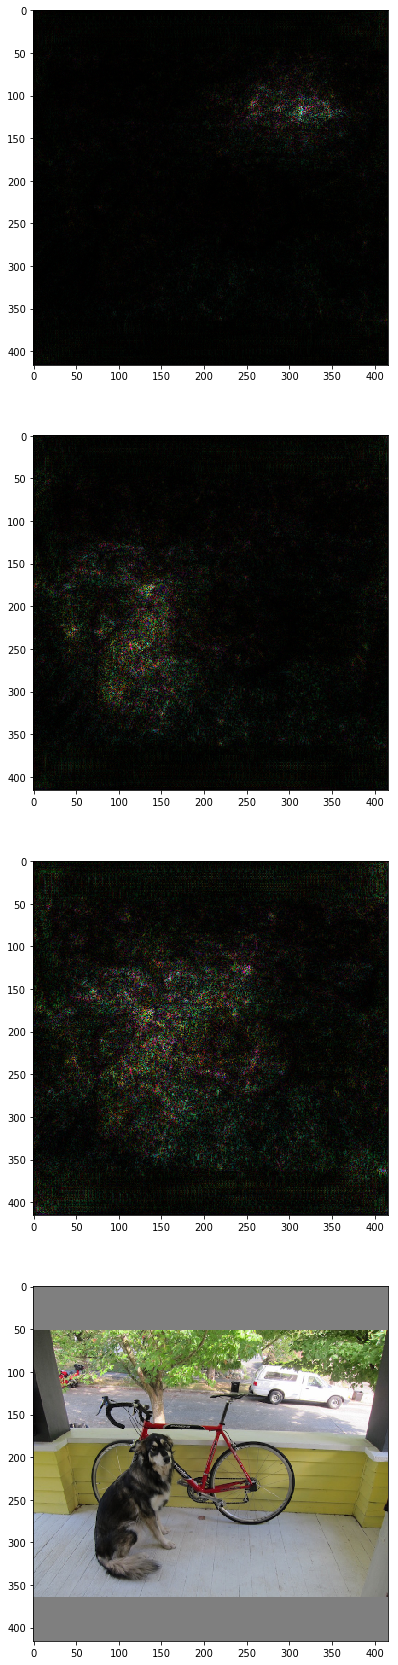

In [12]:
img2Saliency(imgs[0]) 